# ViT training with Pytorch

### 20 Epoch model

used the following github repo for guidance with training

https://github.com/sumn2u/LULC-Mapping



In [1]:
# https://github.com/philschmid/keras-vision-transformer-huggingface/blob/master/image-classification.ipynb

# try this as well
# https://nathanbaileyw.medium.com/implementing-a-vision-transformer-classifier-in-pytorch-0ec02192ab30
# https://huggingface.co/docs/transformers/model_doc/vit

#https://github.com/sumn2u/LULC-Mapping

In [2]:

# Visualization purpose
#%pip install tensorboardX
#!pip install tensorboard
#!pip install tensorboard-plugin-customizable-plots
#%pip install seaborn
#%pip install torchsummary
#%pip install timm

In [3]:
# import libraries
import os
import random
from tqdm.notebook import tqdm
import time

# processing and visualisation libraries
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np

# Pytorch DL libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# seed
SEED = 42
np.random.seed(SEED)

In [4]:
# check for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# gets GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cuda:0
GPU: Tesla T4


In [5]:
# class to load input and target dor dataset along with labels
class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # applies image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # gets class labels
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

In [6]:
# data augmentations
input_size = 224

imagenet_mean, imagenet_std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [7]:

# load the dataset
data_dir = r'/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat_RGB'
dataset = datasets.ImageFolder(data_dir)

# gets categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

# creates a SummaryWriter instance to write logs
writer = SummaryWriter()

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


In [8]:
# applies different transformations to train and test sets
train_data = EuroSAT(dataset, train_transform)
test_data = EuroSAT(dataset, test_transform)

# splitsthe dataset into 80% train / 20% test
train_size = 0.8
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:split])
test_data = data.Subset(test_data, indices=indices[split:])
print("Train/test sizes: {}/{}".format(len(train_data), len(test_data)))

Train/test sizes: 21600/5400


In [9]:
# creates dataloader to load data and assemble data in batches
num_workers = 2
batch_size = 64

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True
)

In [10]:
import torch.nn as nn
import timm

class ViTModel(nn.Module):
    def __init__(self, num_classes):
        super(ViTModel, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        self.model.head = nn.Identity()  # removes existing head
        num_features = 768  # number of features for 'vit_base_patch16_224'
        self.classifier = nn.Linear(num_features, num_classes)


    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x

In [11]:
model_name="vit-base-patch16-224-20-epoch"
# creates vit model instance
num_classes = len(dataset.classes)
model = ViTModel(num_classes)
model = model.to(device)

In [12]:
# summary of the model
torchsummary.summary(model.model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
          Identity-5             [-1, 197, 768]               0
          Identity-6             [-1, 197, 768]               0
         LayerNorm-7             [-1, 197, 768]           1,536
            Linear-8            [-1, 197, 2304]       1,771,776
          Identity-9          [-1, 12, 197, 64]               0
         Identity-10          [-1, 12, 197, 64]               0
           Linear-11             [-1, 197, 768]         590,592
          Dropout-12             [-1, 197, 768]               0
        Attention-13             [-1, 197, 768]               0
         Identity-14             [-1, 1

In [13]:
# create directories for train and test logs
train_log_dir = os.path.join("logs", model_name, "train")
test_log_dir = os.path.join("logs", model_name, "test")

# checks directories exist
os.makedirs(train_log_dir, exist_ok=True)
os.makedirs(test_log_dir, exist_ok=True)

# creates train and test logs
train_writer = SummaryWriter(train_log_dir)
test_writer = SummaryWriter(test_log_dir)

In [14]:
# model training settings
n_epochs = 20
lr = 1e-5 #1e-2, 1e-5
weight_decay = 0
grad_clip = 0.1
# specifies criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

In [15]:

# function responsible for training model
def train(model, dataloader, criterion, optimizer, epoch, writer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # zero the parameter gradients
    optimizer.zero_grad()

    # creates forward pass
    outputs = model(inputs)

    # computes the loss
    loss = criterion(outputs, labels)

    # computes loss
    loss.backward()

    # applies gradient clipping
    for param in model.parameters():
      if param.grad is not None:
        param.grad.data = torch.clamp(param.grad.data, -grad_clip, grad_clip)

    # update the weights based on the internally stored gradients
    optimizer.step()

    # calculates statistic
    _, preds = torch.max(outputs, 1)

    # calcualtes running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # calculates epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100

  # logs the loss and accuracy
  writer.add_scalar('Train/Loss', epoch_loss, epoch)
  writer.add_scalar('Train/Accuracy', epoch_accuracy, epoch)

  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [16]:
# eval function to observer performance on the test set
def evaluate(model, dataloader, criterion, epoch, writer):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # calcs epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100

  # logs loss and accuracy for TensorBoard
  writer.add_scalar('Test/Loss', epoch_loss, epoch)
  writer.add_scalar('Test/Accuracy', epoch_accuracy, epoch)

  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [17]:
# keeps track of the best loss and best model weights withlowest loss
best_loss = np.inf
best_model = None

# records start time
start_time = time.time()

### added for charts
### lists for charts
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# train and test over n_epochs
for epoch in range(n_epochs):
  print("Epoch {}".format(epoch+1))
  train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, epoch, writer)
  test_loss, test_accuracy = evaluate(model, test_loader, criterion, epoch, writer)


  ### added for charts
  # store metrics for charts
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  train_accuracies.append(train_accuracy)
  test_accuracies.append(test_accuracy)


  # logs train and test metrics for the current epoch
  writer.add_scalars('Loss', {'Train': train_loss, 'Test': test_loss}, epoch)
  writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
  # logs train and test metrics for the current epoch using appropriate writers
  train_writer.add_scalars('Loss', {'Train': train_loss, 'Test': test_loss}, epoch)
  train_writer.add_scalars('Accuracy', {'Train': train_accuracy, 'Test': test_accuracy}, epoch)
  if test_loss < best_loss:
    best_loss = test_loss
    best_model= model.state_dict()

# recrods end time
end_time = time.time()

# calcs the total training time
training_time = end_time - start_time
print("Total training time: {:.2f} seconds".format(training_time))

Epoch 1


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.31; Accuracy: 89.86


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.07; Accuracy: 97.59
Epoch 2


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.14; Accuracy: 95.50


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.06; Accuracy: 97.98
Epoch 3


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.13; Accuracy: 95.75


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.20
Epoch 4


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.11; Accuracy: 96.42


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.04; Accuracy: 98.20
Epoch 5


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.11; Accuracy: 96.66


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.46
Epoch 6


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.10; Accuracy: 96.78


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.04; Accuracy: 98.80
Epoch 7


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.09; Accuracy: 97.09


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.06; Accuracy: 98.06
Epoch 8


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.09; Accuracy: 97.11


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.03; Accuracy: 98.96
Epoch 9


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.09; Accuracy: 97.22


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.04; Accuracy: 98.69
Epoch 10


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.09; Accuracy: 97.18


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.04; Accuracy: 98.67
Epoch 11


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.08; Accuracy: 97.46


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.03; Accuracy: 99.04
Epoch 12


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.08; Accuracy: 97.57


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.33
Epoch 13


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.08; Accuracy: 97.69


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.04; Accuracy: 98.81
Epoch 14


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.07; Accuracy: 97.82


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.03; Accuracy: 98.81
Epoch 15


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.07; Accuracy: 97.89


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.50
Epoch 16


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.07; Accuracy: 97.84


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.05; Accuracy: 98.39
Epoch 17


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.07; Accuracy: 97.71


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.03; Accuracy: 99.02
Epoch 18


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.06; Accuracy: 97.99


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.03; Accuracy: 98.91
Epoch 19


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.06; Accuracy: 97.92


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.04; Accuracy: 99.06
Epoch 20


  0%|          | 0/338 [00:00<?, ?it/s]

Train Loss: 0.07; Accuracy: 97.93


  0%|          | 0/85 [00:00<?, ?it/s]

Test Loss: 0.03; Accuracy: 99.26
Total training time: 14762.60 seconds


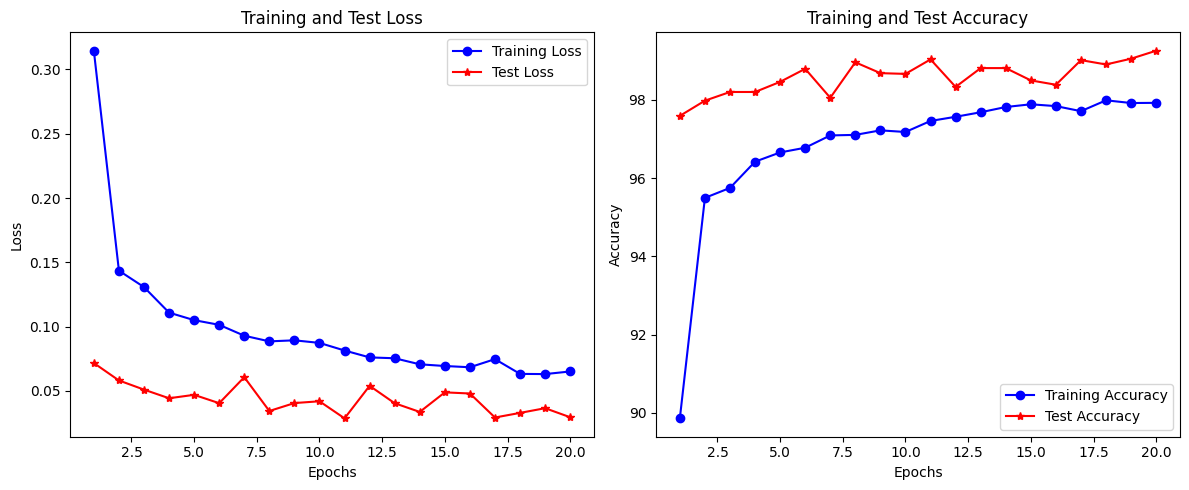

In [18]:
# function for plotting
# The code for the charts is based on code from pp74-75 from Deep Learning with Python [8].
# function to create charts for training and validation loss/accuracy
# based on code from p75 DLWP

# this is to fix issue with plotting when held as tensors and using gpu
def tensor_to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()  # move to CPU, and convert to NumPy
    elif isinstance(tensor, list):  # process each item if its a list
        return np.array([t.detach().cpu().numpy() if isinstance(t, torch.Tensor) else t for t in tensor])
    return np.array(tensor)  # convert to NumPy arrays

def plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # convert tensors to numpy
    train_losses = tensor_to_numpy(train_losses)
    test_losses = tensor_to_numpy(test_losses)
    train_accuracies = tensor_to_numpy(train_accuracies)
    test_accuracies = tensor_to_numpy(test_accuracies)

    plt.figure(figsize=(12, 5))

    # plots train and test loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, test_losses, 'r*-', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, test_accuracies, 'r*-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Execute function
plot_loss_accuracy(train_losses, test_losses, train_accuracies, test_accuracies)

In [19]:
# closes the SummaryWriter
writer.close()
train_writer.close()
test_writer.close()

In [20]:
# saves model
model_dir = r'Users/richesmith/Eurosat Training/Cleaned Project Files'

if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, f'{model_name}_model.pth')

torch.save(best_model, model_file)
print('Model successfully saved to {}'.format(model_file))

Model successfully saved to Users/richesmith/Eurosat Training/Cleaned Project Files/vit-base-patch16-224-20-epoch_model.pth


# Evaluation

In [21]:

import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# predictions and true labels
true_labels = [class_names[label] for _, label in test_data]
predicted_labels = []

batch_size = 32 
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# moves model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# sets model to evaluation mode
model.eval()

with torch.no_grad():
    for batch_images, batch_labels in test_loader:
        batch_images = batch_images.to(device)
        batch_output = model(batch_images)
        _, batch_preds = torch.max(batch_output, 1)
        predicted_labels.extend([class_names[pred] for pred in batch_preds])

# converts labels to numerical values for sklearn metrics
label_mapping = {class_name: i for i, class_name in enumerate(class_names)}
true_labels_numeric = [label_mapping[label] for label in true_labels]
predicted_labels_numeric = [label_mapping[label] for label in predicted_labels]

# calcs classification metrics
accuracy = accuracy_score(true_labels_numeric, predicted_labels_numeric)
precision = precision_score(true_labels_numeric, predicted_labels_numeric, average='weighted')
recall = recall_score(true_labels_numeric, predicted_labels_numeric, average='weighted')
f1 = f1_score(true_labels_numeric, predicted_labels_numeric, average='weighted')

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

# generates classification report
class_report = classification_report(true_labels_numeric, predicted_labels_numeric, target_names=class_names)
print("Classification Report:\n", class_report)

# creates conf matrix
conf_matrix = confusion_matrix(true_labels_numeric, predicted_labels_numeric)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 99.26%
Precision: 0.99
Recall: 0.99
F1-score: 0.99
Classification Report:
                       precision    recall  f1-score   support

          AnnualCrop       0.99      0.99      0.99       597
              Forest       1.00      1.00      1.00       600
HerbaceousVegetation       0.99      0.98      0.99       557
             Highway       0.99      1.00      0.99       493
          Industrial       0.99      1.00      1.00       512
             Pasture       0.98      0.99      0.99       374
       PermanentCrop       0.98      0.99      0.98       491
         Residential       1.00      1.00      1.00       607
               River       1.00      0.99      0.99       547
             SeaLake       1.00      1.00      1.00       622

            accuracy                           0.99      5400
           macro avg       0.99      0.99      0.99      5400
        weighted avg       0.99      0.99      0.99      5400

Confusion Matrix:
 [[589   0   0   0   0   4

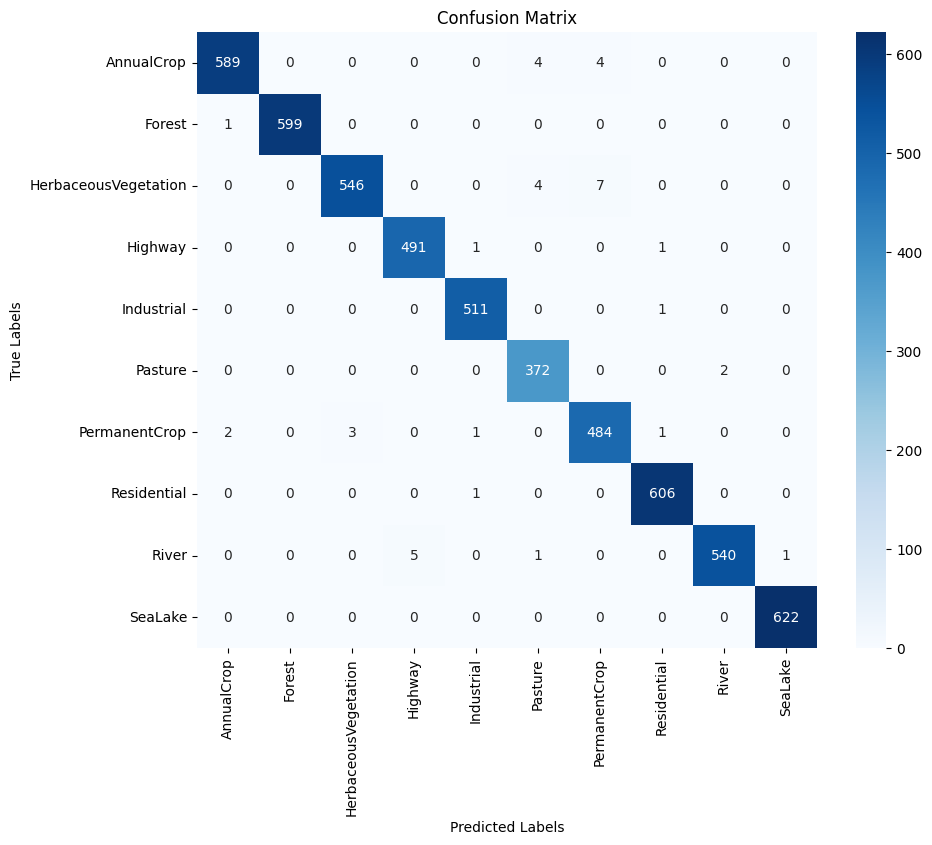

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# generate confusion matrix
conf_matrix = confusion_matrix(true_labels_numeric, predicted_labels_numeric)

# visualises confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

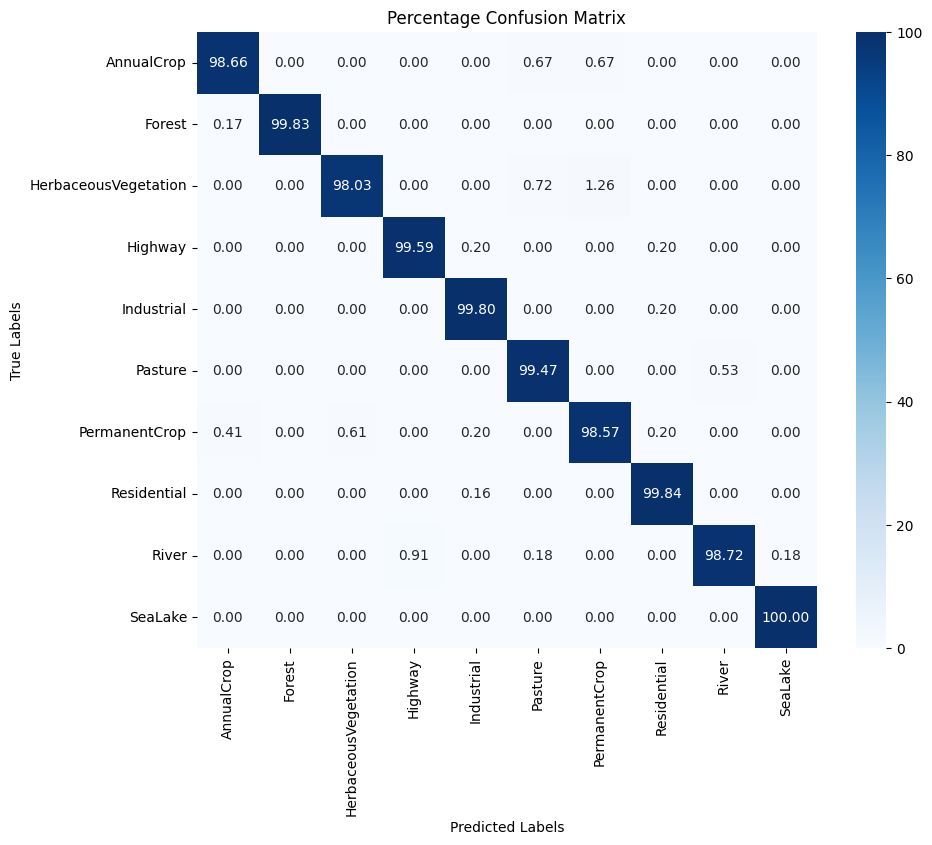

In [23]:
# normalises conf matrix

normalized_conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
percentage_conf_matrix = normalized_conf_matrix * 100  # conversts to percentages

plt.figure(figsize=(10, 8))
sns.heatmap(percentage_conf_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Percentage Confusion Matrix")
plt.show()
